In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance, ks_2samp

import matplotlib.pyplot as plt

def view_single_distribution(
    df,
    metric="area",
    bins=50,
    density=True,
    ax=None,
    title_prefix=""
):
    """
    View a histogram of a single metric from a DataFrame containing
    columns like: ['video', 'frame', 'area', 'eccentricity', 'solidity', 'perimeter'].

    Args:
        df (pd.DataFrame): The input DataFrame.
        metric (str): Which column to visualize, e.g. 'area', 'eccentricity', 'solidity', 'perimeter'.
        bins (int): Number of histogram bins.
        density (bool): Whether to normalize the histogram (density=True) or show counts (density=False).
        ax (matplotlib.axes.Axes, optional): Matplotlib Axes to plot on. 
            If None, a new figure/axes is created.
        title_prefix (str, optional): An optional prefix added to the plot title (e.g. "Real" or "Generated").

    Returns:
        matplotlib.axes.Axes: The axes on which the histogram was plotted.
    """
    if metric not in df.columns:
        raise ValueError(
            f"Metric '{metric}' not found in DataFrame columns. "
            f"Available columns: {df.columns.tolist()}"
        )

    # Drop any NaN or invalid values
    values = df[metric].dropna()

    # Create new figure/axes if none provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))

    # Plot histogram
    ax.hist(values, bins=bins, alpha=0.7, edgecolor="black", density=density)
    ax.set_title(f"{title_prefix} {metric.capitalize()} Distribution")
    ax.set_xlabel(metric)
    ax.set_ylabel("Density" if density else "Count")

    return ax

def compare_distributions_wasserstein(df_real, df_gen, metric):
    """Compute Wasserstein distance for the given metric."""
    real_values = df_real[metric].dropna()
    gen_values  = df_gen[metric].dropna()
    return wasserstein_distance(real_values, gen_values)

def compare_distributions_ks(df_real, df_gen, metric):
    """Compute KS statistic for the given metric."""
    real_values = df_real[metric].dropna()
    gen_values  = df_gen[metric].dropna()
    ks_stat, ks_pval = ks_2samp(real_values, gen_values)
    return ks_stat, ks_pval

def plot_overlaid_histograms(df_real, df_gen, metric, ax, bins=50):
    """Plot two overlaid histograms for the given metric."""
    real_values = df_real[metric].dropna()
    gen_values  = df_gen[metric].dropna()
    ax.hist(real_values, bins=bins, alpha=0.5, label="Real", density=True)
    ax.hist(gen_values,  bins=bins, alpha=0.5, label="Generated", density=True)
    ax.set_xlabel(metric)
    ax.set_ylabel("Density")
    ax.legend()

In [10]:
############################################################
# 1) LOAD PROLIFERATION DATAFRAMES
###########################################################
BASE = "../../results/t2v"
BASE_IDR = f"{BASE}/IDR0013-FILTERED-Test"
END = "all_morphology.csv"
individual_dfs = {
    "all": pd.read_csv(f"{BASE_IDR}/{END}"),
    "cc-high": pd.read_csv(f"{BASE_IDR}-cc-HIGH/{END}"),
    "cc-low": pd.read_csv(f"{BASE_IDR}-cc-LOW/{END}"),
    "pr-high": pd.read_csv(f"{BASE_IDR}-pr-HIGH/{END}"),
    "pr-low": pd.read_csv(f"{BASE_IDR}-pr-LOW/{END}"),
    "ms-high": pd.read_csv(f"{BASE_IDR}-ms-HIGH/{END}"),
    "ms-low": pd.read_csv(f"{BASE_IDR}-ms-LOW/{END}"),
    "prompt_pr_pr-HIGH": pd.read_csv(f"{BASE}/prompt_pr_pr-HIGH/{END}"),
    "prompt_pr_pr-LOW": pd.read_csv(f"{BASE}/prompt_pr_pr-LOW/{END}"),
    "prompt_cc_cc-HIGH": pd.read_csv(f"{BASE}/prompt_cc_cc-HIGH/{END}"),
    "prompt_cc_cc-LOW": pd.read_csv(f"{BASE}/prompt_cc_cc-LOW/{END}"),
    "prompt_ms_ms-HIGH": pd.read_csv(f"{BASE}/prompt_ms_ms-HIGH/{END}"),
    "prompt_ms_ms-LOW": pd.read_csv(f"{BASE}/prompt_ms_ms-LOW/{END}"),
    "phenotype_alive_alive": pd.read_csv(f"{BASE}/phenotype_alive_alive/{END}"),
    "phenotype_dead_dead": pd.read_csv(f"{BASE}/phenotype_dead_dead/{END}"),
    "phenotype_cc_cc-HIGH": pd.read_csv(f"{BASE}/phenotype_cc_cc-HIGH/{END}"),
    "phenotype_cc_cc-LOW": pd.read_csv(f"{BASE}/phenotype_cc_cc-LOW/{END}"),
    "phenotype_ms_ms-HIGH": pd.read_csv(f"{BASE}/phenotype_ms_ms-HIGH/{END}"),
    "phenotype_ms_ms-LOW": pd.read_csv(f"{BASE}/phenotype_ms_ms-LOW/{END}"),
    "uncond_frames81": pd.read_csv(f"{BASE}/uncond_frames81/{END}"),
    # "phenotype_pr_pr-HIGH": pd.read_csv(f"{BASE}/phenotype_pr_pr-HIGH/{END}"),
    # "phenotype_pr_pr-LOW": pd.read_csv(f"{BASE}/phenotype_pr_pr-LOW/{END}"),
}

# Create merged dataframes
prompt_dfs = {k: v for k, v in individual_dfs.items() if k.startswith("prompt_")}
phenotype_dfs = {k: v for k, v in individual_dfs.items() if k.startswith("phenotype_")}

# Merge dataframes
prompt_merged = pd.concat(prompt_dfs.values())
phenotype_merged = pd.concat(phenotype_dfs.values())

# Create final dictionary with merged dataframes
dfs = {
    "all": individual_dfs["all"],
    # "cc-high": individual_dfs["cc-high"],
    # "cc-low": individual_dfs["cc-low"],
    # "pr-high": individual_dfs["pr-high"],
    # "pr-low": individual_dfs["pr-low"],
    # "ms-high": individual_dfs["ms-high"],
    # "ms-low": individual_dfs["ms-low"],
    "prompt_all": prompt_merged,
    "phenotype_all": phenotype_merged,
    "uncond_frames81": individual_dfs["uncond_frames81"],
}

# Print info about the merged datasets
print(f"Merged {len(prompt_dfs)} prompt datasets into 'prompt_all' with {len(prompt_merged)} rows")
print(f"Merged {len(phenotype_dfs)} phenotype datasets into 'phenotype_all' with {len(phenotype_merged)} rows")

Merged 6 prompt datasets into 'prompt_all' with 450739 rows
Merged 6 phenotype datasets into 'phenotype_all' with 823371 rows


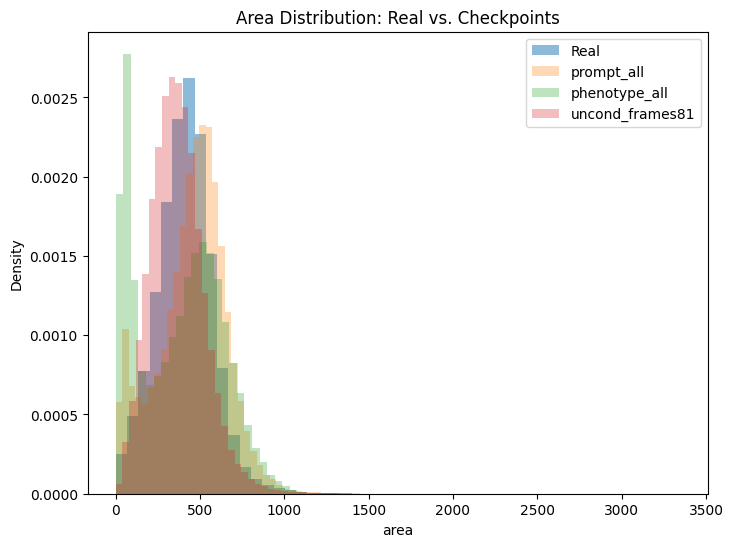

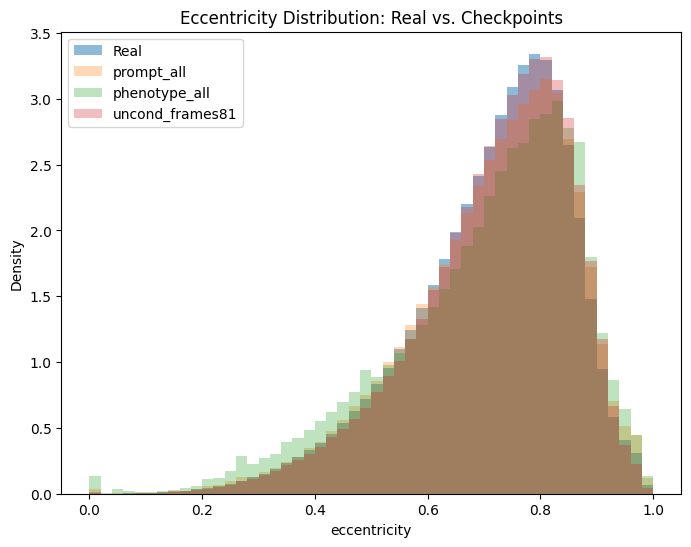

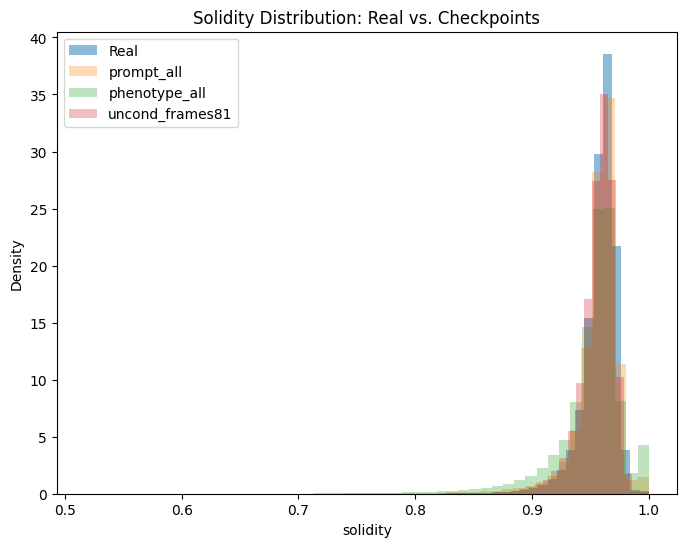

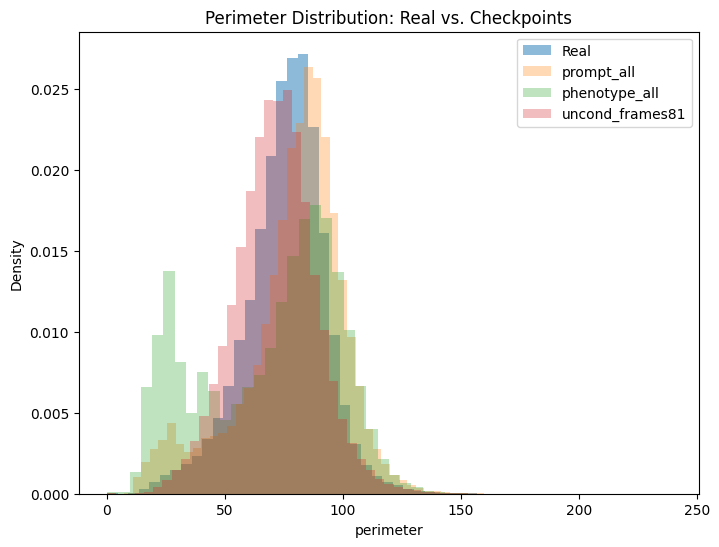

In [11]:
import matplotlib.pyplot as plt

metrics = ["area", "eccentricity", "solidity", "perimeter"]

for metric in metrics:
    plt.figure(figsize=(8,6))
    # Plot real distribution
    plt.hist(dfs["all"][metric].dropna(), bins=50, alpha=0.5, density=True, label="Real")
    
    # Plot each checkpoint overlayed
    for name, df in dfs.items():
        if name == "all":
            continue
        plt.hist(df[metric].dropna(), bins=50, alpha=0.3, density=True, label=name)
    
    plt.title(f"{metric.capitalize()} Distribution: Real vs. Checkpoints")
    plt.xlabel(metric)
    plt.ylabel("Density")
    plt.legend()
    plt.show()

In [8]:
import pandas as pd
from scipy.stats import wasserstein_distance, ks_2samp

metrics = ["area", "eccentricity", "solidity", "perimeter"]
results = []

for checkpoint_name, df_gen in dfs.items():
    if checkpoint_name == "all":
        continue
    for metric in metrics:
        real_vals = dfs["all"][metric].dropna()
        gen_vals  = df_gen[metric].dropna()
        
        wdist  = wasserstein_distance(real_vals, gen_vals)
        ks_stat, ks_pval = ks_2samp(real_vals, gen_vals)
        
        results.append({
            "checkpoint": checkpoint_name,
            "metric": metric,
            "wasserstein_distance": wdist,
            "ks_stat": ks_stat,
            "ks_pval": ks_pval
        })

df_results = pd.DataFrame(results)
df_results

,checkpoint,metric,wasserstein_distance,ks_stat,ks_pval
0,cc-high,area,13.192026,0.042278,0.000000e+00
1,cc-high,eccentricity,0.005467,0.019923,1.287602e-240
2,cc-high,solidity,0.000360,0.007498,1.927985e-34
3,cc-high,perimeter,1.433775,0.046487,0.000000e+00
4,cc-low,area,36.700368,0.105594,0.000000e+00
5,cc-low,eccentricity,0.002832,0.017034,1.120712e-32
6,cc-low,solidity,0.000523,0.019630,2.960852e-43
7,cc-low,perimeter,3.521062,0.108994,0.000000e+00
8,pr-high,area,9.119072,0.020295,0.000000e+00
9,pr-high,eccentricity,0.001191,0.005395,1.446188e-41


In [9]:
for metric in metrics:
    # Filter rows for this metric
    subdf = df_results[df_results["metric"] == metric].copy()
    
    # Sort by wasserstein_distance ascending (lowest distance = best)
    subdf = subdf.sort_values("wasserstein_distance")
    
    print(f"\n=== Ranking for '{metric}' by Wasserstein Distance ===")
    display(subdf[["checkpoint", "metric", "wasserstein_distance"]])


=== Ranking for 'area' by Wasserstein Distance ===


,checkpoint,metric,wasserstein_distance
16,ms-high,area,4.794669
8,pr-high,area,9.119072
0,cc-high,area,13.192026
20,ms-low,area,16.115728
12,pr-low,area,21.539599
4,cc-low,area,36.700368
32,uncond_frames81,area,46.098095
24,prompt_all,area,56.956628
28,phenotype_all,area,87.017438



=== Ranking for 'eccentricity' by Wasserstein Distance ===


,checkpoint,metric,wasserstein_distance
17,ms-high,eccentricity,0.000790
9,pr-high,eccentricity,0.001191
5,cc-low,eccentricity,0.002832
13,pr-low,eccentricity,0.003024
21,ms-low,eccentricity,0.004737
1,cc-high,eccentricity,0.005467
25,prompt_all,eccentricity,0.005605
33,uncond_frames81,eccentricity,0.006769
29,phenotype_all,eccentricity,0.021212



=== Ranking for 'solidity' by Wasserstein Distance ===


,checkpoint,metric,wasserstein_distance
18,ms-high,solidity,0.000344
2,cc-high,solidity,0.000360
6,cc-low,solidity,0.000523
22,ms-low,solidity,0.001034
10,pr-high,solidity,0.001061
34,uncond_frames81,solidity,0.002152
26,prompt_all,solidity,0.002592
14,pr-low,solidity,0.002827
30,phenotype_all,solidity,0.010065



=== Ranking for 'perimeter' by Wasserstein Distance ===


,checkpoint,metric,wasserstein_distance
19,ms-high,perimeter,0.572366
11,pr-high,perimeter,1.063954
3,cc-high,perimeter,1.433775
23,ms-low,perimeter,1.845893
15,pr-low,perimeter,2.556679
7,cc-low,perimeter,3.521062
35,uncond_frames81,perimeter,4.299708
27,prompt_all,perimeter,6.084928
31,phenotype_all,perimeter,11.253350
